In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV,KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, make_scorer
from sklearn.tree import plot_tree
from joblib import dump, load
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv("macro-economic-db-quarterly.csv", delimiter=";", index_col=0)
df = df.transpose()

df.reset_index(inplace=True)
df.rename(columns={"index":"stvrtrok"}, inplace=True)
for column in df.columns[1:]:
    df[column] = df[column].str.replace(",", "").astype(float)

columns_to_modify = df.columns.difference(["urok"])
df[columns_to_modify] = df[columns_to_modify].replace(0, np.nan)

df["bilancia"] = df.vyvoz - df.dovoz

df["NaN_Percentage"] = df.isna().sum(axis=1) / df.shape[1] * 100
df_cut =  df[df["NaN_Percentage"] <= 30].drop(columns=["NaN_Percentage"])
df_cut.reset_index(drop=True, inplace=True)

df_clean = df_cut.bfill()
df_clean = df_clean.ffill()

In [3]:
#Rozdelenie dát

#HDP
X_hdp = df_clean[df_clean.columns.difference(["hdp", "stvrtrok"])]
y_hdp = df_clean.hdp
X_train_hdp, X_test_hdp, y_train_hdp, y_test_hdp = train_test_split(X_hdp, y_hdp, test_size=0.2, random_state=42)


#Nezamestnanosť
X_nezamestnanost = df_clean[df_clean.columns.difference(["nezamestnanost", "stvrtrok"])]
y_nezamestnanost = df_clean.nezamestnanost
X_train_nezamestnanost, X_test_nezamestnanost, y_train_nezamestnanost, y_test_nezamestnanost = train_test_split(X_nezamestnanost, y_nezamestnanost, test_size=0.2, random_state=42)


#Inflácia
X_cpi = df_clean[df_clean.columns.difference(["cpi", "stvrtrok"])]
y_cpi = df_clean.cpi
X_train_cpi, X_test_cpi, y_train_cpi, y_test_cpi = train_test_split(X_cpi, y_cpi, test_size=0.2, random_state=42)

In [5]:
#XGBoost model pre HDP
xgb_model_hdp = XGBRegressor(objective='reg:squarederror', random_state=42)

# Definovanie mriežky hyperparametrov
param_grid_hdp = {
    'n_estimators': [50, 100, 200, 300],  # Počet stromov v lese
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Rýchlosť učenia
    'max_depth': [3, 4, 5, 6, 8, 10],  # Maximálna hĺbka stromu
    'subsample': [0.6, 0.8, 1.0],  # Podiel vzoriek použitých na trénovanie každého stromu
    'colsample_bytree': [0.6, 0.8, 1.0],  # Podiel vlastností použitých pri každom rozdelení stromu
    'gamma': [0, 0.1, 0.2, 0.5],  # Regularizácia na zabránenie pretrénovania
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularizácia
    'reg_lambda': [0, 0.01, 0.1, 1]  # L2 regularizácia
}

# Definovanie vlastného skórovacieho metriky pre optimalizáciu
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Grid Search pre optimalizáciu hyperparametrov
grid_search_hdp = GridSearchCV(
    estimator=xgb_model_hdp,
    param_grid=param_grid_hdp,
    cv=5,  # Počet foldov pri krížovej validácii
    scoring=mape_scorer,
    n_jobs=-1  # Paralelné spracovanie
)

# Trénovanie modelu na trénovacej množine
grid_search_hdp.fit(X_train_hdp, y_train_hdp)

# Najlepšie nájdené hyperparametre
best_params_hdp = grid_search_hdp.best_params_
best_model_hdp = grid_search_hdp.best_estimator_

print("Najlepšie hyperparametre:", best_params_hdp)

# Predikcia na testovacej množine
y_pred_hdp = best_model_hdp.predict(X_test_hdp)

# Výpočet metrik pre hodnotenie modelu
mae_hdp = mean_absolute_error(y_test_hdp, y_pred_hdp)
mse_hdp = mean_squared_error(y_test_hdp, y_pred_hdp)
rmse_hdp = np.sqrt(mse_hdp)
mape_hdp = mean_absolute_percentage_error(y_test_hdp, y_pred_hdp)
r2_hdp = r2_score(y_test_hdp, y_pred_hdp)

print(f"(MAE): {mae_hdp}")
print(f"(MSE): {mse_hdp}")
print(f"(RMSE): {rmse_hdp}")
print(f"(MAPE): {mape_hdp}")
print(f"R²: {r2_hdp}")


Najlepšie hyperparametre: {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 0, 'subsample': 0.8}
(MAE): 212.02085230978264
(MSE): 87349.27611854841
(RMSE): 295.54910948698256
(MAPE): 0.01285829543249712
R²: 0.9966887961459535


In [ ]:
#XGBoost model pre Nezamestnanosť
xgb_model_nezamestnanost = XGBRegressor(objective='reg:squarederror', random_state=42)

# Definovanie mriežky hyperparametrov
param_grid_nezamestnanost = {
    'n_estimators': [50, 100, 200, 300],  # Počet stromov v lese
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Rýchlosť učenia
    'max_depth': [3, 4, 5, 6, 8, 10],  # Maximálna hĺbka stromu
    'subsample': [0.6, 0.8, 1.0],  # Podiel vzoriek použitých na trénovanie každého stromu
    'colsample_bytree': [0.6, 0.8, 1.0],  # Podiel vlastností použitých pri každom rozdelení stromu
    'gamma': [0, 0.1, 0.2, 0.5],  # Regularizácia na zabránenie pretrénovania
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularizácia
    'reg_lambda': [0, 0.01, 0.1, 1]  # L2 regularizácia
}

# Definovanie vlastného skórovacieho metriky pre optimalizáciu
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Grid Search pre optimalizáciu hyperparametrov
grid_search_nezamestnanost = GridSearchCV(
    estimator=xgb_model_nezamestnanost,
    param_grid=param_grid_nezamestnanost,
    cv=5,  # Počet foldov pri krížovej validácii
    scoring=mape_scorer,
    n_jobs=-1  # Paralelné spracovanie
)

# Trénovanie modelu na trénovacej množine
grid_search_nezamestnanost.fit(X_train_nezamestnanost, y_train_nezamestnanost)

# Najlepšie nájdené hyperparametre
best_params_nezamestnanost = grid_search_nezamestnanost.best_params_
best_model_nezamestnanost = grid_search_nezamestnanost.best_estimator_

print("Najlepšie hyperparametre:", best_params_nezamestnanost)

# Predikcia na testovacej množine
y_pred_nezamestnanost = best_model_nezamestnanost.predict(X_test_nezamestnanost)

# Výpočet metrik pre hodnotenie modelu
mae_nezamestnanost = mean_absolute_error(y_test_nezamestnanost, y_pred_nezamestnanost)
mse_nezamestnanost = mean_squared_error(y_test_nezamestnanost, y_pred_nezamestnanost)
rmse_nezamestnanost = np.sqrt(mse_nezamestnanost)
mape_nezamestnanost = mean_absolute_percentage_error(y_test_nezamestnanost, y_pred_nezamestnanost)
r2_nezamestnanost = r2_score(y_test_nezamestnanost, y_pred_nezamestnanost)

print(f"(MAE): {mae_nezamestnanost}")
print(f"(MSE): {mse_nezamestnanost}")
print(f"(RMSE): {rmse_nezamestnanost}")
print(f"(MAPE): {mape_nezamestnanost}")
print(f"R²: {r2_nezamestnanost}")




Najlepšie hyperparametre: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': None, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0.01, 'subsample': 1.0}
(MAE): 0.502436730459462
(MSE): 0.6558832222874945
(RMSE): 0.8098661755422896
(MAPE): 0.04043143019199251
R²: 0.9568219926984288


In [ ]:
#XGBoost model pre CPI
xgb_model_cpi = XGBRegressor(objective='reg:squarederror', random_state=42)

# Definovanie mriežky hyperparametrov
param_grid_cpi = {
    'n_estimators': [50, 100, 200, 300],  # Počet stromov v lese
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Rýchlosť učenia
    'max_depth': [3, 4, 5, 6, 8, 10],  # Maximálna hĺbka stromu
    'subsample': [0.6, 0.8, 1.0],  # Podiel vzoriek použitých na trénovanie každého stromu
    'colsample_bytree': [0.6, 0.8, 1.0],  # Podiel vlastností použitých pri každom rozdelení stromu
    'gamma': [0, 0.1, 0.2, 0.5],  # Regularizácia na zabránenie pretrénovania
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularizácia
    'reg_lambda': [0, 0.01, 0.1, 1]  # L2 regularizácia
}

# Definovanie vlastného skórovacieho metriky pre optimalizáciu
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Grid Search pre optimalizáciu hyperparametrov
grid_search_cpi = GridSearchCV(
    estimator=xgb_model_cpi,
    param_grid=param_grid_cpi,
    cv=5,  # Počet foldov pri krížovej validácii
    scoring=mape_scorer,
    n_jobs=-1  # Paralelné spracovanie
)

# Trénovanie modelu na trénovacej množine
grid_search_cpi.fit(X_train_cpi, y_train_cpi)

# Najlepšie nájdené hyperparametre
best_params_cpi = grid_search_cpi.best_params_
best_model_cpi = grid_search_cpi.best_estimator_

print("Najlepšie hyperparametre:", best_params_cpi)

# Predikcia na testovacej množine
y_pred_cpi = best_model_cpi.predict(X_test_cpi)

# Výpočet metrik pre hodnotenie modelu
mae_cpi = mean_absolute_error(y_test_cpi, y_pred_cpi)
mse_cpi = mean_squared_error(y_test_cpi, y_pred_cpi)
rmse_cpi = np.sqrt(mse_cpi)
mape_cpi = mean_absolute_percentage_error(y_test_cpi, y_pred_cpi)
r2_cpi = r2_score(y_test_cpi, y_pred_cpi)

print(f"(MAE): {mae_cpi}")
print(f"(MSE): {mse_cpi}")
print(f"(RMSE): {rmse_cpi}")
print(f"(MAPE): {mape_cpi}")
print(f"R²: {r2_cpi}")




In [ ]:
#Uloženie modelov

#dump(best_model_hdp, 'best_model_hdp_xgb.joblib')
#dump(best_model_nezamestnanost, 'best_model_nezamestnanost_xgb.joblib')
#dump(best_model_cpi, 'best_model_cpi_xgb.joblib')

['best_model_cpi_xgb.joblib']

In [4]:
xgb_loaded_hdp = load('best_model_hdp_xgb.joblib')
xgb_loaded_nezamestnanost = load('best_model_nezamestnanost_xgb.joblib')
xgb_loaded_cpi = load('best_model_cpi_xgb.joblib')

In [17]:
y_pred_cpi = xgb_loaded_cpi.predict(X_test_cpi)

# Výpočet metrik pre hodnotenie modelu
mae_cpi = mean_absolute_error(y_test_cpi, y_pred_cpi)
mse_cpi = mean_squared_error(y_test_cpi, y_pred_cpi)
rmse_cpi = np.sqrt(mse_cpi)
mape_cpi = mean_absolute_percentage_error(y_test_cpi, y_pred_cpi)
r2_cpi = r2_score(y_test_cpi, y_pred_cpi)

print(f"(MAE): {mae_cpi}")
print(f"(MSE): {mse_cpi}")
print(f"(RMSE): {rmse_cpi}")
print(f"(MAPE): {mape_cpi}")
print(f"R²: {r2_cpi}")

(MAE): 1.8894245828379745
(MSE): 12.055527774462991
(RMSE): 3.472107108725621
(MAPE): 0.014150914910235384
R²: 0.9944034581172607


In [5]:
#Metriky

hdp_pred_loaded = xgb_loaded_hdp.predict(X_test_hdp)
nezamestnanost_pred_loaded = xgb_loaded_nezamestnanost.predict(X_test_nezamestnanost)
cpi_pred_loaded = xgb_loaded_cpi.predict(X_test_cpi)

mae_nezamestnanost_loaded = mean_absolute_error(y_test_nezamestnanost, nezamestnanost_pred_loaded)
mse_nezamestnanost_loaded = mean_squared_error(y_test_nezamestnanost, nezamestnanost_pred_loaded)
rmse_nezamestnanost_loaded = np.sqrt(mse_nezamestnanost_loaded)
mape_nezamestnanost_loaded = mean_absolute_percentage_error(y_test_nezamestnanost, nezamestnanost_pred_loaded)
r2_nezamestnanost_loaded = r2_score(y_test_nezamestnanost, nezamestnanost_pred_loaded)

mae_hdp_loaded = mean_absolute_error(y_test_hdp, hdp_pred_loaded)
mse_hdp_loaded = mean_squared_error(y_test_hdp, hdp_pred_loaded)
rmse_hdp_loaded = np.sqrt(mse_hdp_loaded)
mape_hdp_loaded = mean_absolute_percentage_error(y_test_hdp, hdp_pred_loaded)
r2_hdp_loaded = r2_score(y_test_hdp, hdp_pred_loaded)

mae_cpi_loaded = mean_absolute_error(y_test_cpi, cpi_pred_loaded)
mse_cpi_loaded = mean_squared_error(y_test_cpi, cpi_pred_loaded)
rmse_cpi_loaded = np.sqrt(mse_cpi_loaded)
mape_cpi_loaded = mean_absolute_percentage_error(y_test_cpi, cpi_pred_loaded)
r2_cpi_loaded = r2_score(y_test_cpi, cpi_pred_loaded)

metrics = {
    "Cieľová premenná": [
        "HDP",
        "Nezamestnanosť",
        "Inflácia"
    ],
    "MSE": [
        mse_hdp_loaded,
        mse_nezamestnanost_loaded,
        mse_cpi_loaded
    ],
    "MAE": [
        mae_hdp_loaded,
        mae_nezamestnanost_loaded,
        mae_cpi_loaded,
    ],
    "RMSE": [
        rmse_hdp_loaded,
        rmse_nezamestnanost_loaded,
        rmse_cpi_loaded
    ],
    "MAPE": [
        mape_hdp_loaded,
        mape_nezamestnanost_loaded,
        mape_cpi_loaded
    ],
    "R2": [
        r2_hdp_loaded,
        r2_nezamestnanost_loaded,
        r2_cpi_loaded
    ]
}

df_metrics = pd.DataFrame(metrics)
df_metrics






,Cieľová premenná,MSE,MAE,RMSE,MAPE,R2
0,HDP,87349.276119,212.020852,295.549109,0.012858,0.996689
1,Nezamestnanosť,0.655883,0.502437,0.809866,0.040431,0.956822
2,Inflácia,12.055528,1.889425,3.472107,0.014151,0.994403


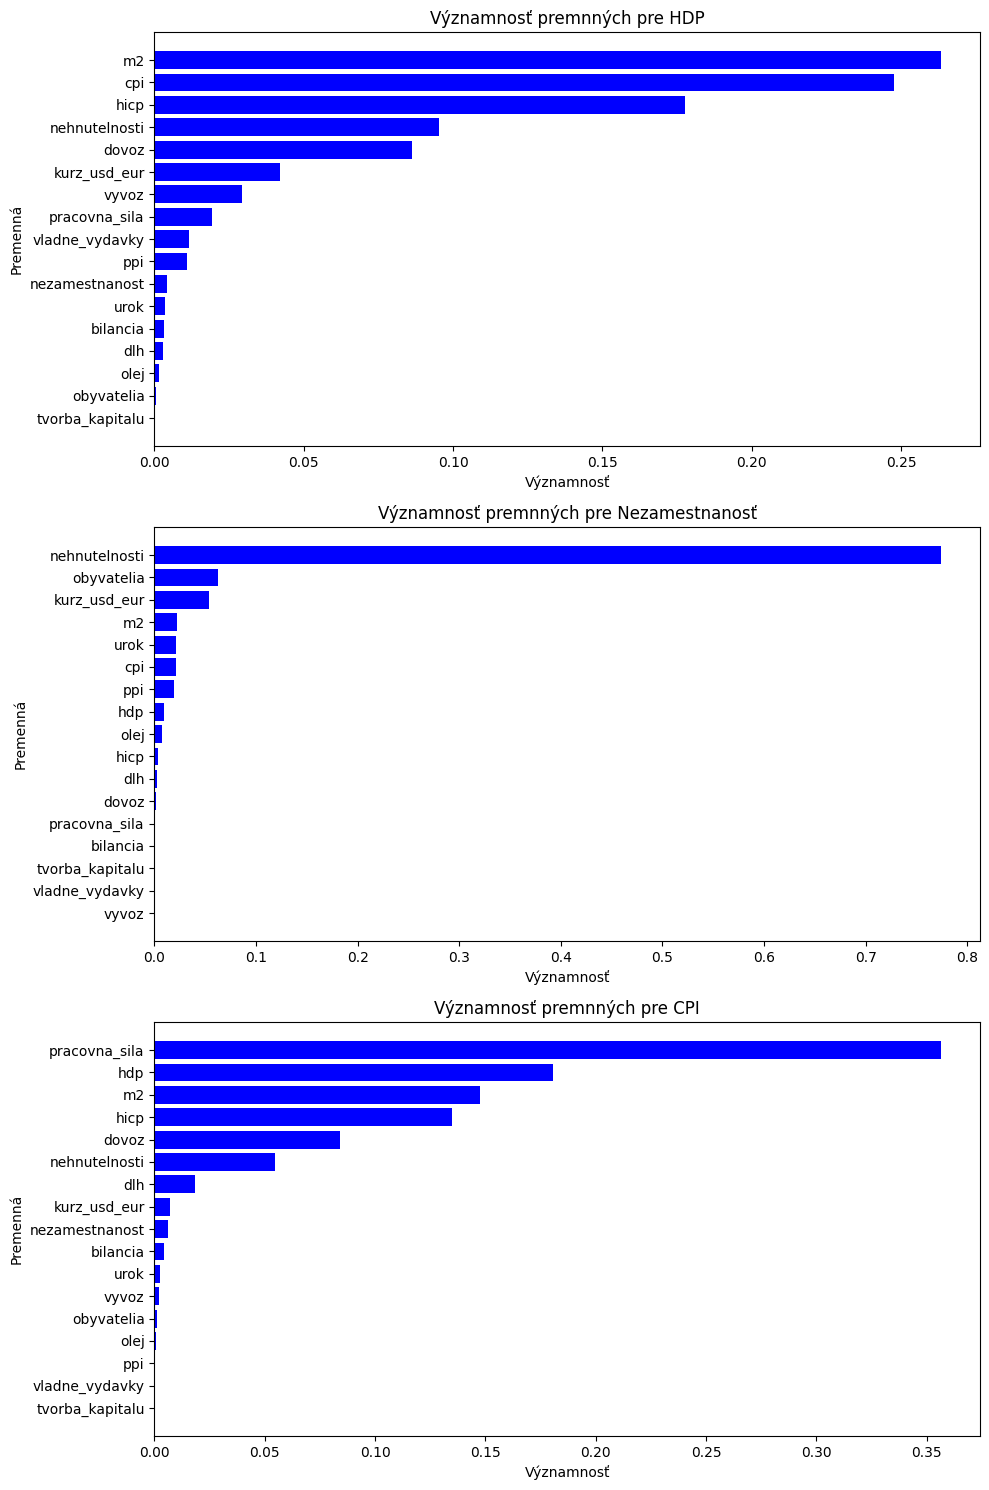

In [7]:
#Významnosť premnných
models = {
    "hdp": xgb_loaded_hdp,
    "nezamestnanost": xgb_loaded_nezamestnanost,
    "cpi": xgb_loaded_cpi
}

feature_importance_results = {}

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

for idx, (target, model) in enumerate(models.items()):

    
    X = eval(f"X_train_{target}")

    
    importances = model.feature_importances_
    feature_names = X.columns

    
    feature_importance_df = pd.DataFrame({
        "Premenná": feature_names,
        "Významnosť": importances
    }).sort_values(by="Významnosť", ascending=False)

    
    feature_importance_results[target] = feature_importance_df

    if target == "hdp":
        target = "HDP"
    elif target == "cpi":
        target = "CPI"
    else:
        target = "Nezamestnanosť"
    
    axes[idx].barh(feature_importance_df["Premenná"], feature_importance_df["Významnosť"], color="blue")
    axes[idx].set_xlabel("Významnosť")
    axes[idx].set_ylabel("Premenná")
    axes[idx].set_title(f"Významnosť premnných pre {target}")
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()





In [8]:
feature_importance_df

,Premenná,Významnosť
12,pracovna_sila,0.356291
3,hdp,0.180413
6,m2,0.147634
4,hicp,0.134705
2,dovoz,0.084240
7,nehnutelnosti,0.054799
1,dlh,0.018302
5,kurz_usd_eur,0.006997
8,nezamestnanost,0.006019
0,bilancia,0.004485
